In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import partial

In [31]:
# TODO (maybe) add convergence of the marginals for perturb and map shcemes, 
# and check with multiple temperatures of sum-of-gammas
# use some other more appropriate distance rather than L2 (eg KL div.)

In [2]:
rng = np.random.RandomState()

In [3]:
# n choose k; top-k distribution (over n) 
n = 5
k = 3

In [4]:
# generate random parameters 
theta = rng.randn(n)

In [6]:
def weight(x):  # maybe not useful... 
    return np.dot(theta, x)

In [7]:
# create all possible_states:
combs = list(itertools.combinations(range(n), k))
n_states = len(combs)
assert n_states == np.math.factorial(n)/(np.math.factorial(k)*np.math.factorial(n-k))
print('Number of possible states:', n_states)
mat_x = np.zeros((len(combs), n))
for i in range(n_states):
    mat_x[i, combs[i]] = 1.

Number of possible states: 10


In [8]:
# create table of weights
table_of_weights = mat_x @ theta

In [9]:
# log partition fuction (that depends on theta)
Z = np.log(np.sum(np.exp(table_of_weights)))

In [10]:
# table of probabilities (aka probability mass function)
pmf = np.exp(table_of_weights - Z)
assert abs(np.sum(pmf) - 1) < 1.e-10  # checking that it sums to 1. (more or less)

In [11]:
def get_pmf(_theta):
    _tow = mat_x @ _theta
    _Z = np.log(np.sum(np.exp(_tow)))
    return np.exp(_tow - _Z)

def MAP(_theta):
    """This is the MAP, according to Eq. (2) of the paper. 
    (this is the same as taking the state with the highest k theta_i..)"""
    _pmf = get_pmf(_theta)
    return np.argmax(_pmf)

In [12]:
# compute true marginals 
marginals_from_pmf = (pmf.reshape((1, n_states)) @ mat_x).reshape((n,))

<BarContainer object of 5 artists>

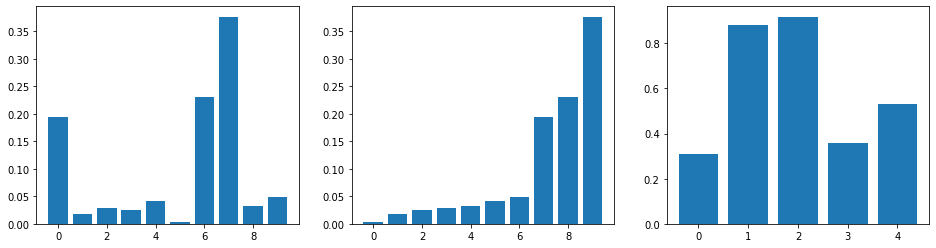

In [13]:
# jsut a plot of the probability mass funciton unsorted and sorted
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
ax[1].bar(range(n_states), sorted(pmf));
# plt.show()
ax[0].bar(range(n_states), pmf);
ax[2].bar(range(n), marginals_from_pmf)

In [14]:
# define sampler for Gumbel(0, 1) and sum of Gammas from th 1

def sample_gumbel(size):
    return -np.log(-np.log(np.random.uniform(size=size)))

def sample_sum_of_gammas(_k, size, s=100):
    """These should be the epsilons from Th. 1. """
    return (np.sum([
        np.random.gamma(1./_k, _k/i, size=size) for i in range(1, s+1)
    ], axis=0) - np.log(s))/_k

def no_perturb(size):
    return np.zeros(size)

sample_sog_k = partial(sample_sum_of_gammas, k)

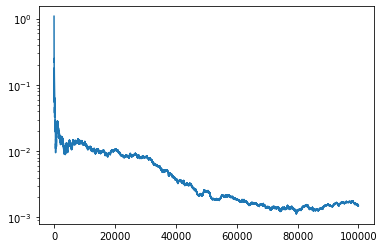

In [15]:
# preposition 1 first. We perturb the table of weiths with gumbels
samples = 100000
amaxx = []
empirical_pmf_gumb_p1 = np.zeros((n_states))
norm_of_diff = []
for i in range(samples):
    mapp = np.argmax(table_of_weights + sample_gumbel(n_states))  # taking the MAP
    amaxx.append(mapp)  # perturb and map (the table of weights)
    empirical_pmf_gumb_p1[mapp] += 1
    norm_of_diff.append(np.linalg.norm(empirical_pmf_gumb_p1/(i+1) - pmf))
plt.semilogy(norm_of_diff)
# looks good... seems to converge toward 0 (albeit slowly). 
# I'm just computing the Euclidan distance between the two PMF. I know it's not correct, 
# but still should go toward 0..

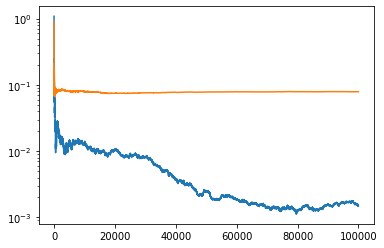

In [16]:
# let's try to perturb the weighs now
samples = 100000
amaxx = []
empirical_pmf_gumb_p1 = np.zeros((n_states))
norm_of_diff_perturb_weights = []
for i in range(samples):
    mapp = MAP(theta + sample_gumbel(n))
    amaxx.append(mapp)  # perturb and map (the table of weights)
    empirical_pmf_gumb_p1[mapp] += 1
    norm_of_diff_perturb_weights.append(np.linalg.norm(empirical_pmf_gumb_p1/(i+1) - pmf))
plt.semilogy(norm_of_diff)
plt.semilogy(norm_of_diff_perturb_weights)
# ok, this is good.. now..

In [17]:
# let' try th 1...

In [26]:
def sog_th1(s=10, temp=1.):
    return (temp/k)*(
        np.sum([rng.gamma(1./k, (1.0*k)/(i+1.)) for i in range(s)]) - np.log(s)
    )

In [20]:
sog_th1()

-0.4345262273046096

In [21]:
# check that the sum behaves like gumbel
n_samples = 10000
samples = []
for i in range(n_samples):
    samples.append(np.sum([sog_th1() for _ in range(k)]))

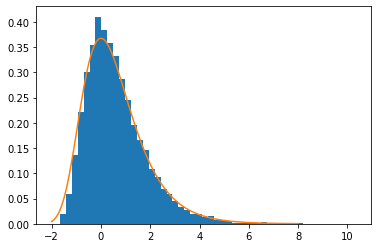

In [22]:
plt.hist(samples, density=True, bins=50);
x = np.linspace(-2, 8, num=100)
plt.plot(x, np.exp(-x - np.exp(-x)))
# seems good

In [36]:
# perturbation of the weights with sum-of-gammas
temperature = k
samples = 100000
amaxx = []
empirical_pmf_sog_th1 = np.zeros((n_states))
norm_of_diff_perturb_weights_sog = []
save_sum_of_perturbations_actually_used = []

for i in range(samples):
    sog_perturbation = np.array([sog_th1(temp=temperature) for _ in range(n)])
    tilde_theta = theta + sog_perturbation
    
    mapp = MAP(tilde_theta)
    x_mappp = mat_x[mapp]
    
    save_sum_of_perturbations_actually_used.append(np.dot(sog_perturbation, x_mappp))
    amaxx.append(mapp)  # perturb and map (the table of weights)
    empirical_pmf_sog_th1[mapp] += 1
    norm_of_diff_perturb_weights_sog.append(np.linalg.norm(empirical_pmf_sog_th1/(i+1) - pmf))

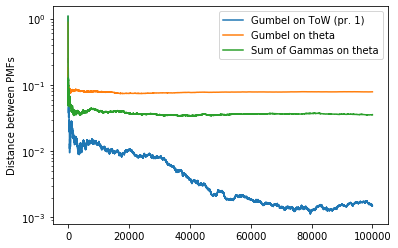

In [37]:
plt.semilogy(norm_of_diff, label='Gumbel on ToW (pr. 1)')
plt.semilogy(norm_of_diff_perturb_weights, label='Gumbel on theta')
plt.semilogy(norm_of_diff_perturb_weights_sog, label='Sum of Gammas on theta')
plt.legend(loc=0)
plt.ylabel('Distance between PMFs');

In [29]:
empirical_pmf_sog_th1/samples, pmf

(array([0.21385, 0.01612, 0.0233 , 0.02847, 0.03991, 0.00454, 0.2444 ,
        0.35996, 0.02549, 0.04396]),
 array([0.19512162, 0.01712324, 0.02794816, 0.02536373, 0.04139811,
        0.00363296, 0.23075961, 0.37664056, 0.03305275, 0.04895926]))

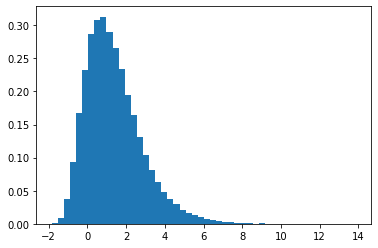

In [26]:
plt.hist(save_sum_of_perturbations_actually_used, density=True, bins=50);
# these again look good.. 

One thing that came to my mind is that by perturbing the weiights only (with any distribution actually), it's basically the same (in expectation) as summing to the table of weights the same number, which leads to sampling basically the same state. 

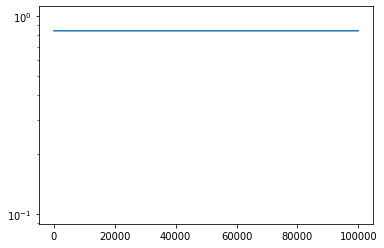

In [27]:
# preposition 1 first. We perturb the table of weiths with gumbels
samples = 100000
amaxx = []
empirical_pmf_gumb_p1 = np.zeros((n_states))
norm_of_diff = []
for i in range(samples):
    one_gumbel = sample_gumbel(None)
    mapp = np.argmax(table_of_weights + one_gumbel)
    amaxx.append(mapp)  # perturb and map (the table of weights)
    empirical_pmf_gumb_p1[mapp] += 1
    norm_of_diff.append(np.linalg.norm(empirical_pmf_gumb_p1/(i+1) - pmf))
plt.semilogy(norm_of_diff)
# looks good... kind of

In [27]:
print(empirical_pmf_gumb_p1/samples)
# this is of course the map state

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [28]:
print(empirical_pmf_sog_th1/samples)
# in fact the empirical PMF is quite close to the map state....

[6.5000e-04 3.7890e-02 4.1780e-02 3.5000e-04 4.1000e-04 2.8730e-02
 8.7200e-03 9.4200e-03 8.6544e-01 6.6100e-03]


In [28]:
# let us now perturb the table of weights with independent sum of gammas. 
# this is of course not feasible in practice, but still...
samples = 100000
amaxx = []
empirical_pmf_sog_th1_tow = np.zeros((n_states))
norm_of_diff_perturb_weights_sog_tow = []

for i in range(samples):
    tow_pert = []
    for st in mat_x: # cycle w.r.t. the states
        sog_perturbation = np.array([sog_th1() for _ in range(n)])
        tilde_theta = theta + sog_perturbation
        tow_pert.append(tilde_theta @ st)
    
    mapp = np.argmax(tow_pert)

    amaxx.append(mapp)  # perturb and map (the table of weights)
    empirical_pmf_sog_th1_tow[mapp] += 1
    norm_of_diff_perturb_weights_sog_tow.append(np.linalg.norm(empirical_pmf_sog_th1_tow/(i+1) - pmf))

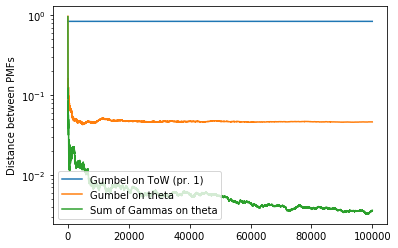

In [30]:
plt.semilogy(norm_of_diff, label='Gumbel on ToW (pr. 1)')
plt.semilogy(norm_of_diff_perturb_weights, label='Gumbel on theta')
plt.semilogy(norm_of_diff_perturb_weights_sog_tow, label='Sum of Gammas on theta')
plt.legend(loc=0)
plt.ylabel('Distance between PMFs');

In [34]:
empirical_pmf_sog_th1_tow/samples, pmf

(array([0.14442, 0.09534, 0.06352, 0.08424, 0.05645, 0.03657, 0.20528,
        0.13932, 0.09261, 0.08225]),
 array([0.14175128, 0.09508767, 0.06470998, 0.08364373, 0.05692203,
        0.03818367, 0.20472011, 0.13931809, 0.09345548, 0.08220797]))